<a href="https://colab.research.google.com/github/tamarvooijs/Applied-Machine-Learning/blob/master/AppliedMachineLearning/AppliedMachineLearning_Week7_CNN_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# CS4305TU: Week 7 - Convolutional Neural Networks - Assignment
## Renote sensing classification using CNNs
*14 & 18 Nov 2021*

*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)

---


# Notebook instructions
 
In assignment 7 on CNNs you will work on landcover classification of Sentinel-2 satellite image patches using:
 * ANNs (Step 1)
 * CNNs (Step 2) 
 * Transfer learning (Step3) 
 
and instance segmentation of impervious surface from Landsat-8 satellite images using:
 * U-nets (Step 4)
 
To do the analysis and answer the questions, you can draw a lot form the snippets of codes we used in the example notebook. We ask you to train each model for only 5 epochs. Off course you are free to run more (and it would increase performance), but 5 should already be good enough to see the tendencies to interpret the questions). Moreover, I strongly recommend to start the notebook with GPU-accelerator. Otherwise, training might take very long.

For each of the steps, there is :
 * a short introduction in markdown which you should remove from the notebook you hand-in
 * a set of questions marked with `[code]` where we ask you to write code to do the required steps
 * a set of questions marked with `[text]` where we ask you to respond to the question with written text in a markdown cell

## Submission instructions

- Answer the questions (code and/or text) in this notebook
- Rename this file by adding your group nomber (e.g. Assignment_groupXX.ipynb)
- Submit your assignment in 3 ways:
 - .ipynb notebook (*File->Download*)
 - pdf print (*File->Print->Save as pdf*) 
 - a link to your colab notebook (*Share->Get Link*) and make sure you change the settings to *\"Anyone on the internet with this link can view\"*
 

# Q1-3: classification of the eurosat dataset

In step 1-3, we ask you to do a classification on the `eurosat/rgb` dataset and you can find more information about it at the corresponding [keras datasets page](https://www.tensorflow.org/datasets/catalog/eurosat).

You can simply load the data where we split the data into 75/25\% training/validation.

In [49]:
import tensorflow_datasets as tfds
import tensorflow as tf
ds_train, info = tfds.load('eurosat/rgb', split='train[:75%]', as_supervised=True, shuffle_files=True, with_info=True)
ds_val, info = tfds.load('eurosat/rgb', split='train[75%:]', as_supervised=True, shuffle_files=False, with_info=True)

The result is a tdfs.DataSet over which you can iterate and modify etc. You can find more info on the [DataSet help page](https://www.tensorflow.org/datasets/overview#iterate_over_a_dataset), but here is already a simple example to load one example to load it for visualization:

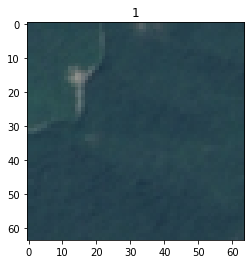

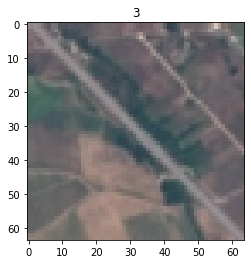

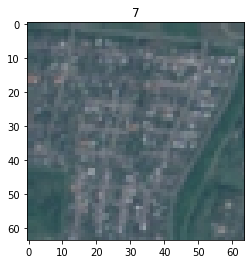

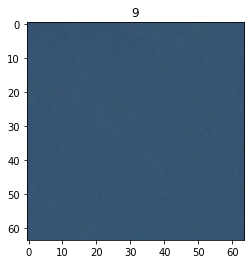

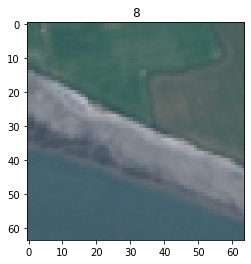

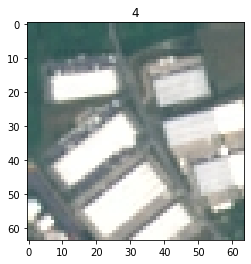

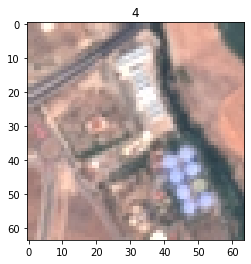

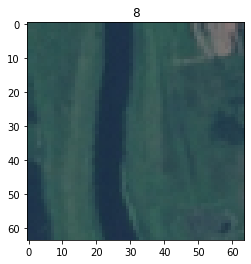

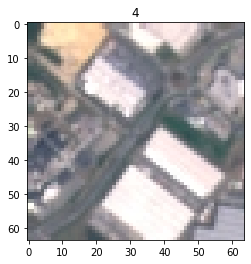

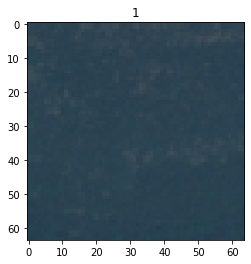

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

temp = ds_train.take(10).as_numpy_iterator()
for i in temp:
  plt.figure()
  plt.imshow(i[0])
  plt.title(i[1])

Or by using the built-in `tfds.show_examples` function:

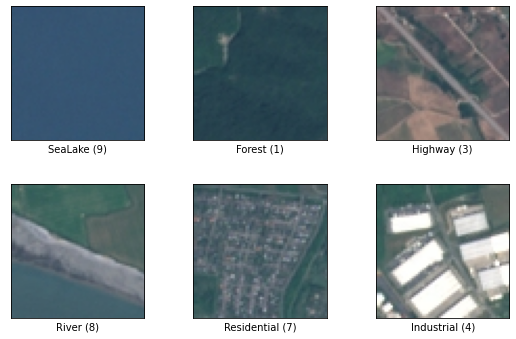

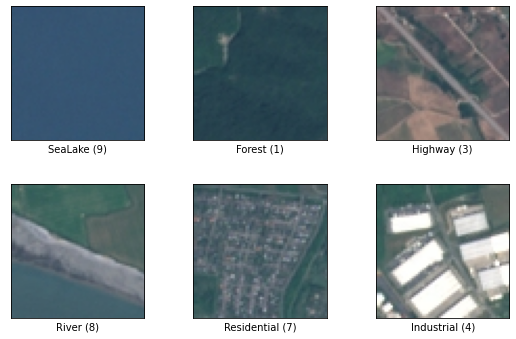

In [51]:
tfds.show_examples(ds_train.take(6), info)

When loading the data into your network, you probably need to cache, batch and prefetch them to increase [performance](https://www.tensorflow.org/guide/data_performance#prefetching). In this case, you should not worry about it and just run it after loading the data

In [52]:
ds_train = ds_train.cache()
ds_train = ds_train.batch(128)
ds_train.prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.batch(128)
ds_val = ds_val.cache()
ds_val.prefetch(tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.uint8, tf.int64)>

After this, the data can go directly into the `model.fit()` function with `model.fit(ds_train, epochs=5, batch_size=128, validation_data=ds_val)`

In [53]:
def plot_loss_and_accuracy(history, title_label_loss):
    # plot loss
    plt.subplot(211)
    plt.title(title_label_loss)
    plt.plot(history['loss'], color='blue', label='train')
    plt.plot(history['val_loss'], color='red', label='test')
    plt.ylim(0,2)
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history['accuracy'], color='blue', label='train')
    plt.plot(history['val_accuracy'], color='red', label='test')
    plt.ylim(0,1)
    # add legend
    plt.legend()
    # Tweak spacing between subplots to prevent labels from overlapping
    plt.subplots_adjust(hspace=0.5)
    return

## Q1.1: ANN
 - `[code]` build a classical ANN to classify these Eurosat images with the following characteristics (where `FC[x,y]` = fully-connected layers with `x` neurons and `y` activation): `input->FC[100, relu]->FC[10, relu]->FC[10]` and train it for 5 epochs to classify eurosat dataset.
 - `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for both training and validation datasets
 - `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
 - `[text]` shortly (max 5 sentences) explain which loss function you implemented for training the network and why

## Q2.1: CNN
* `[code]` build a CNN to classify these Eurosat images during 5 epochs with the following characteristics where:
 *  `CNN[x*x,y,z,pad, act]` = Conv2D layers with a `x*x` kernel size, `y` filters, `z` stride, `pad` padding and `act` activation) 
 * `MaxPool[x*x,pad]`: MaxPool layer with a `x*x` pool_size and `pad` padding
 * `input -> block 1 -> block 2 -> block 3 -> FC block`, where
   * Block 1: `CNN[5*5,25,1,'same','relu]->MaxPool[2*2,'same']`
   * Block 2: `CNN[5*5,50,1,'same','relu]->CNN[3*3,50,1,'same','relu]->MaxPool[2*2,'same']`
   * Block 3: `CNN[3*3,70,2,'same','relu]->CNN[3*3,50,1,'same','relu]->MaxPool[2*2,'same']`
   * FC block: `FC[100, relu]->FC[10, relu]->FC[10]`
* `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for both training and validation datasets for both the ANN (Q1.1)and CNN (Q2.1)
* `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
* `[text]` shortly discuss the difference between the ANN and CNN in terms of accuracy, learning rate, overfitting risk and difference in architecture (e.g. number of trainable parameters, layers, ...)
* `[text]` shortly discuss what would be the effect of replacing the `5*5` kernel sizes of block 1+2 by a sequence of 2 `3*3` filters in terms of receptive fields and trainable parameters
* `[text]` shortly discuss what would be the effect of batch normalisation at the end of every block on generalization and overfitting

## Q3.1: Transfer learning


* `[code]` use transfer learning as a feature extraction by loading the VGG16 and ResNet50 models with fixed weights and by adding a `FC[100, relu]->FC[10, relu]->FC[10]` at the end. Use these models to again train/validate the `eurosat/rgb` dataset during 5 epochs.
* `[code]` make a plot with two subpanels that shows the loss (panel 1) and accuracy (panel 2) for your CNN of Q2.1 and the VGG16, Resnet.


Start evaluating the adapted VGG16 model ...

Epoch 1/5
159/159 [==============================] - 20s 119ms/step - loss: 1.8565 - accuracy: 0.3488 - val_loss: 1.4455 - val_accuracy: 0.5013
Epoch 2/5
159/159 [==============================] - 18s 114ms/step - loss: 1.2337 - accuracy: 0.5711 - val_loss: 0.9673 - val_accuracy: 0.6791
Epoch 3/5
159/159 [==============================] - 18s 114ms/step - loss: 0.7129 - accuracy: 0.7797 - val_loss: 0.7173 - val_accuracy: 0.8049
Epoch 4/5
159/159 [==============================] - 18s 114ms/step - loss: 0.4750 - accuracy: 0.8600 - val_loss: 0.6113 - val_accuracy: 0.8492
Epoch 5/5
159/159 [==============================] - 18s 114ms/step - loss: 0.3285 - accuracy: 0.9014 - val_loss: 0.5300 - val_accuracy: 0.8692
Training complete

Loss and accuracy plot for the adapted VGG16 model:


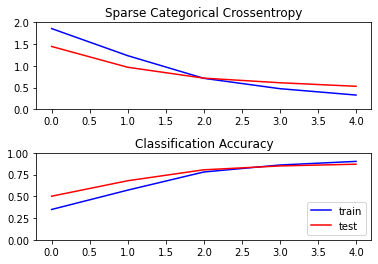


Start evaluating the adapted ResNet50 model ...

Epoch 1/5
159/159 [==============================] - 23s 123ms/step - loss: 0.6856 - accuracy: 0.7965 - val_loss: 0.3970 - val_accuracy: 0.8963
Epoch 2/5
159/159 [==============================] - 18s 116ms/step - loss: 0.2417 - accuracy: 0.9312 - val_loss: 0.3298 - val_accuracy: 0.9092
Epoch 3/5
159/159 [==============================] - 18s 116ms/step - loss: 0.1282 - accuracy: 0.9611 - val_loss: 0.3785 - val_accuracy: 0.9043
Epoch 4/5
159/159 [==============================] - 18s 116ms/step - loss: 0.0878 - accuracy: 0.9716 - val_loss: 0.3475 - val_accuracy: 0.9144
Epoch 5/5
159/159 [==============================] - 18s 116ms/step - loss: 0.0650 - accuracy: 0.9791 - val_loss: 0.4277 - val_accuracy: 0.9022
Training complete

Loss and accuracy plot for the adapted ResNet50 model:


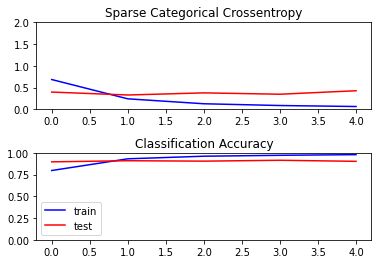

In [54]:
#########################
### Transfer learning ###
#########################
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

input_shape = (64, 64, 3)
init_models = {'VGG16':    VGG16(include_top=False, input_shape=input_shape), 
               'ResNet50': ResNet50(include_top=False, input_shape=input_shape)}
models      = {}

for label in init_models.keys():
    print(f"\nStart evaluating the adapted {label} model ...\n")
    # mark init_model layers as not trainable
    for layer in init_models[label].layers:
        layer.trainable = False

    # add new classifier layers
    flat1  = Flatten()(init_models[label].layers[-1].output)
    class1 = Dense(100, activation='relu')(flat1)
    class2 = Dense(10, activation='relu')(class1)
    output = Dense(10, activation='softmax')(class2)

    # define new model
    models[label] = Model(inputs=init_models[label].inputs, outputs=output)
    # print(f"\nNew {label} Model summary:")
    # print(models[label].summary())

    # Compiling the model, add a loss function, optimiser, and metrics to track during training
    models[label].compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss      = tf.keras.losses.sparse_categorical_crossentropy,
        metrics   = ['accuracy']
        )
    
    # The fit function allows you to fit the compiled model to some training data
    history = models[label].fit(ds_train, epochs=5, batch_size=128, validation_data=ds_val)
    print('Training complete\n')

    # Plot the loss and accuracy for the model training
    print(f"Loss and accuracy plot for the adapted {label} model:")
    plot_loss_and_accuracy(history.history, 'Sparse Categorical Crossentropy')
    plt.show()


* `[text]` shortly discuss the difference between your CNN and the tranfer models in terms of accuracy, learning rate, overfitting risk and difference in architecture (e.g. number of trainable parameters, layers, ...). 

* `[text]` shortly discuss the (dis-)advantages of each model

* `[code]` repeat the transfer learning by loading the architecture of the ResNet50 model but without fixing the weights. 


Start evaluating the ResNet50 model ...

Epoch 1/5
159/159 [==============================] - 58s 326ms/step - loss: 0.8492 - accuracy: 0.7865 - val_loss: 2.7508 - val_accuracy: 0.2219
Epoch 2/5
159/159 [==============================] - 50s 318ms/step - loss: 0.2963 - accuracy: 0.9127 - val_loss: 2.4901 - val_accuracy: 0.4750
Epoch 3/5
159/159 [==============================] - 51s 319ms/step - loss: 0.2840 - accuracy: 0.9138 - val_loss: 1.2470 - val_accuracy: 0.6557
Epoch 4/5
159/159 [==============================] - 51s 318ms/step - loss: 0.5776 - accuracy: 0.8284 - val_loss: 2.1239 - val_accuracy: 0.5779
Epoch 5/5
159/159 [==============================] - 51s 319ms/step - loss: 0.3075 - accuracy: 0.8971 - val_loss: 4.7208 - val_accuracy: 0.2926
Training complete

Loss and accuracy plot for the adapted ResNet50 model:


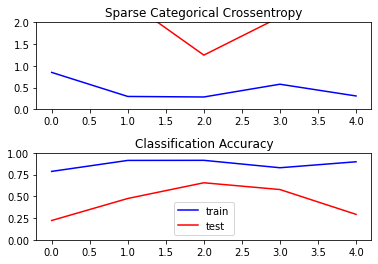

In [64]:
#########################
### Transfer learning ###
#########################
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

input_shape = (64, 64, 3)
init_models = {# 'VGG16':    VGG16(include_top=False, input_shape=input_shape), 
               'ResNet50': ResNet50(include_top=False, input_shape=input_shape)}
models      = {}

for label in init_models.keys():
    print(f"\nStart evaluating the {label} model ...\n")
    # mark init_model layers as not trainable
    # for layer in init_models[label].layers:
    #     layer.trainable = False

    # add new classifier layers
    flat1  = Flatten()(init_models[label].layers[-1].output)
    class1 = Dense(100, activation='relu')(flat1)
    class2 = Dense(10, activation='relu')(class1)
    output = Dense(10, activation='softmax')(class2)

    # define new model
    models[label] = Model(inputs=init_models[label].inputs, outputs=output)
    # print(f"\nNew {label} Model summary:")
    # print(models[label].summary())

    # Compiling the model, add a loss function, optimiser, and metrics to track during training
    models[label].compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss      = tf.keras.losses.sparse_categorical_crossentropy,
        metrics   = ['accuracy']
        )
    
    # The fit function allows you to fit the compiled model to some training data
    history = models[label].fit(ds_train, epochs=5, batch_size=128, validation_data=ds_val)
    print('Training complete\n')

    # Plot the loss and accuracy for the model training
    print(f"Loss and accuracy plot for the adapted {label} model:")
    plot_loss_and_accuracy(history.history, 'Sparse Categorical Crossentropy')
    plt.show()


* `[text]` you can abort this free weights run early if it takes too long, but what can you learn about the (preliminary) accuracy and training time? Shortly discuss the effect of (not) fixing the weights in terms of accuracy, learning rate, computing time.

# Q4: instance segmentation using a U-net

In step 4, we ask you to do a U-net classification on a set of [Landsat-8 imagery downloaded from the Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=en). The data can be found on Brightspace in the Assignment Data section of `Content/week 7`. It contains of a tensorflow datarecord format which can be read using the following preprocessing (which you should not worry about for this assignment)

In [56]:
# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']
BANDS = opticalBands + thermalBands
RESPONSE = 'impervious'
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

In [57]:
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(pattern):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  glob = tf.io.gfile.glob(pattern)
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

BUFFER_SIZE = 2000
BATCH_SIZE = 16

To load the data, you just need to specify the correct folder/filename in colab. We recommend to mount your google drive (where you can store the data) to easily load the data:

In [58]:
# this mounts your Google Drive to the Colab VM and will ask you to authenticate
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [59]:
# For training
# gdrive_filename_training = '/content/drive/MyDrive/fcnn-demo-SL_eval_patches_g0.tfrecord.gz'
gdrive_filename_training = 'fcnn-demo-SL_eval_patches_g0.tfrecord.gz'
dataset = get_dataset(gdrive_filename_training)
training = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [60]:
# For evaluation
# gdrive_filename_training = '/content/drive/MyDrive/fcnn-demo-SL_training_patches_g0.tfrecord.gz'
gdrive_filename_training = 'fcnn-demo-SL_training_patches_g0.tfrecord.gz'
dataset = get_dataset(gdrive_filename_training)
validation = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

You can now load and visualize that data (e.g. band 3 ([Band 3 (green) surface reflectance](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2?hl=en#bands)) or the RGB bands which are bands 1:4 in reversed order as the satellite gives us BGR and we need RGB) with:

In [61]:
temp = training.take(1).as_numpy_iterator()

In [62]:
for i in temp:
  im = i[0][0][:,:,:]
  rgb = np.flip(i[0][0][:,:,1:4],axis=2) # take band 1:4 and flip it from BGR to RGB
  lb = i[1][0][:,:,0]

NameError: ignored

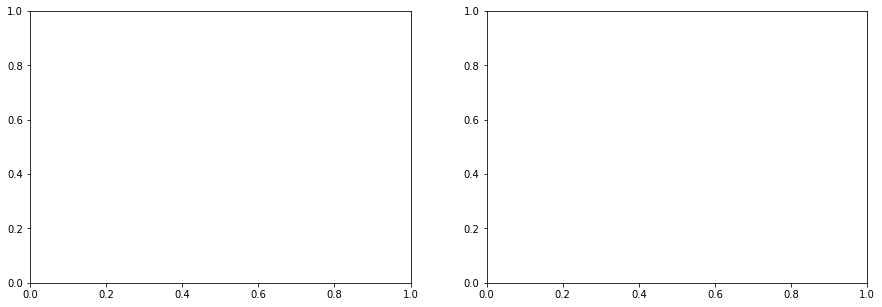

In [63]:
  fig, axs = plt.subplots(1,2,figsize=(15,5))
  i1 = axs[0].imshow(rgb*10)
  axs[0].set_title('RGB')
  i2= axs[1].imshow(lb)
  axs[1].set_title('Imperviousness')
  plt.colorbar(i1)

## Q4.1: homemade U-net

 * `[code]` build a U-net to these Landsat images for imperviousness during 5 epochs. You can copy the structure of the example notebook.
 * `[code]` make a plot with two subpanels that shows the loss (panel 1) and RMSE (panel 2) for U-net
 * `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
 * `[text]` shortly (max 5 sentences) explain which loss function you implemented for training the network and why

As you will see, the performance of the model will be sub-optimal as you would need a lot of epochs and computing power to get good results and this is beyond the goal of the assignment. Therefore, we have also provided a pre-trained model (50 epochs. 25 hours. final RMSE ~0.08), which you can use for predictions right away. You can load the model, which is also in the `Assignment Data section of Content/week 7`:

In [ ]:
m = tf.keras.models.load_model('geemm.h5')

## Q4.2: pre-trained U-net
* `[code]` use the pre-trained model to predict the imperviousness of the validation dataset
* `[code]` plot some images (e.g. 5) with the true and predicted label to illustrate the performance of the model
* `[text]` shortly discuss the performance of the model based on these example images (e.g., where does it seem to be ok, where not, why could that be the case)

# End
I hope you enjoy the assignment. In case of questions, please use the mattermost channel of week 7.